In [66]:
%load_ext watermark
%watermark
import copy
import pickle
import os

import pandas as pd
import pandas_datareader.data as web
from pandas.tseries.offsets import Week
import numpy as np
import sklearn.mixture as mix
from sklearn.externals import joblib
import scipy.stats as scs
from math import ceil

import matplotlib as mpl
import matplotlib.pyplot as plt
#prop = mpl.font_manager.FontProperties(fname='/home/cam/Documents/Brian_/_fonts/Consola Mono/ConsolaMono.ttf')

#from matplotlib.dates import YearLocator, MonthLocator
%matplotlib inline
import seaborn as sns
sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
              'font.family':'Courier Prime Code', 'legend.frameon': True} # 
sns.set_style('white', style_kwds)

import missingno as msno
from tqdm import tqdm
import affirm 
import warnings
warnings.filterwarnings("ignore")
import re
p=print
p()
%watermark -p pandas,pandas_datareader,numpy,scipy,sklearn,matplotlib,seaborn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2017-04-22T23:11:54-06:00

CPython 3.6.0
IPython 5.1.0

compiler   : GCC 4.4.7 20120313 (Red Hat 4.4.7-1)
system     : Linux
release    : 4.4.0-72-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit

pandas 0.19.2
pandas_datareader 0.3.0.post
numpy 1.12.1
scipy 0.19.0
sklearn 0.18.1
matplotlib 2.0.0
seaborn 0.7.1


In [2]:
nSamples = 1_000
year = 2007 # cutoff
lookback = 3 # years
step_fwd = 3 # days
ks = [2,3,5,7,9,13,17,21]
chosen_etfs = ['SPY', 'QQQ', 'TLT', 'GLD', 'EFA', 'EEM']

def _create_dir(DIR, k, lookback, step_fwd, nSamples, year):
    dir_fmt = f'k-{k}_lb-{lookback}_step-{step_fwd}_nsamples-{nSamples}'
    if os.path.isdir(DIR + dir_fmt + '/'): 
        pass
    else: os.makedirs(DIR + dir_fmt + '/')
    return dir_fmt

In [3]:
pkl_loc = '/home/cam/Documents/Brian_/HDD_folders/_Code/Mixture_Models/BottomPicking/chosen_etf_agg_ks_trim/'
f_suffix = f'k-multiple_lb-{lookback}_step-{step_fwd}_nsamples-{nSamples}.txt'
f_suffix

'k-multiple_lb-3_step-3_nsamples-1000.txt'

In [4]:
import sys
DIR = '/home/cam/Documents/Brian_/HDD_folders/_Code/Mixture_Models/BottomPicking/'
sys.path.append(DIR)
import ResultEval 
import ModelPlots
hdf_data = pd.read_hdf(DIR+'mixture_model_merged_data_03.h5', 'table')

In [5]:
# import dict of predictions
# dcts is list of tuples 
#   with tuple = (k, sym, dict)
#     dict = {a, b, pred-df, cutoff-year}

dcts_k_f = pkl_loc + 'dcts_' + f_suffix
dcts_k_f

with open(dcts_k_f, 'rb') as f:
    dcts = pickle.load(f)

In [12]:
for tup in dcts:
    p(tup)
    #p(tup[1])
    break

(2, 'SPY', {'pred':             ith_state   ith_ret   ith_var    low_ci   high_ci       tgt  \
Dates                                                                     
2008-01-02          1 -0.000786  0.000157 -0.020533  0.010249 -0.008793   
2008-01-03          1 -0.000663  0.000157 -0.020309  0.010315 -0.000483   
2008-01-04          1 -0.000667  0.000156 -0.020283  0.010294 -0.024812   
2008-01-07          1 -0.000815  0.000159 -0.020802  0.010353 -0.000850   
2008-01-08          1 -0.000815  0.000160 -0.020875  0.010394 -0.016280   
2008-01-09          1 -0.000927  0.000161 -0.021148  0.010371  0.010455   
2008-01-10          1 -0.000840  0.000161 -0.021037  0.010446  0.006533   
2008-01-11          1 -0.000789  0.000162 -0.021081  0.010550 -0.008101   
2008-01-14          0 -0.000879  0.000162 -0.021247  0.010502  0.008030   
2008-01-15          0 -0.000733  0.000123 -0.016099  0.007853 -0.022259   
2008-01-16          1 -0.000937  0.000165 -0.021687  0.010658 -0.008650   
2008-

In [15]:
dcts[-1]

(21,
 'EEM',
 {'a': 0.2,
  'b': 0.7,
  'pred':             ith_state   ith_ret   ith_var    low_ci   high_ci       tgt  \
  Dates                                                                     
  2008-01-02         19  0.002003  0.000170 -0.019325  0.013920 -0.016638   
  2008-01-03         14 -0.006746  0.000279 -0.041716  0.012795  0.008957   
  2008-01-04         20  0.019232  0.000415 -0.032845  0.048331 -0.030497   
  2008-01-07         14 -0.011383  0.000404 -0.062082  0.016946  0.007300   
  2008-01-08         14  0.007947  0.000421 -0.044807  0.037424 -0.007784   
  2008-01-09         14 -0.005955  0.000231 -0.034918  0.010229  0.032254   
  2008-01-10         14 -0.007850  0.000408 -0.058993  0.020727  0.011716   
  2008-01-11         14  0.007682  0.000319 -0.032276  0.030009 -0.028530   
  2008-01-14         14  0.008224  0.000310 -0.030710  0.029980  0.014602   
  2008-01-15         14 -0.000209  0.000341 -0.042912  0.023653 -0.046287   
  2008-01-16         17 -0.0015

In [80]:
%%time
# aggregate returns by step for each etf

step_fwds = [1, 2, 3, 5, 7, 10, 21]

# agg_etf_ret_by_step is a dict
# key = ETF-symbol, value = list[] of tuples()
agg_etf_ret_by_step = {}
for etf in chosen_etfs:
    # agg_ret_by_step is a temp list
    #  holds identifying information and the etf returns
    agg_ret_by_step = []
    for tup in dcts:
        if tup[1] == etf:
            for step in step_fwds:
                # return k, mkt-symbol and prediction dict from tuple
                k, tmpetf, tmp_data = tup[0], tup[1], tup[2] 

                # create file format
                #  useful for organizing and saving plots
                file_fmt = _create_dir(DIR, k, lookback, step, nSamples, year) 

                # evaluate data by step_fwd
                rev = ResultEval.ResultEval(data=tmp_data, step_fwd=step)
                event_dict = rev.get_event_states()
                # [0]= TOO_HIGH, [1] = TOO_LOW
                event = list(event_dict.keys())[1] 

                pev = rev.get_post_events(event_dict[event])
                etf_return_data = rev.agg_temp_event_returns(pev)
                # tuple is (etf, k, step, and cumulative return data)
                agg_ret_by_step.append((tmpetf, k, step, etf_return_data))
    agg_etf_ret_by_step[etf] = agg_ret_by_step
                #mp = ModelPlots.ModelPlots(etf, pev, event, DIR, file_fmt, year)
                #mp.plot_equity_curve(etf_return_data, benchmark=hdf_data['SPY_lret'])

CPU times: user 2min 27s, sys: 240 ms, total: 2min 27s
Wall time: 2min 27s


In [81]:
# check keys and sample output
p(agg_etf_ret_by_step.keys())
p()
p(agg_etf_ret_by_step['SPY'])

dict_keys(['SPY', 'QQQ', 'TLT', 'GLD', 'EFA', 'EEM'])

[('SPY', 2, 1, Dates
2008-01-04    0.000000
2008-01-07   -0.000850
2008-01-15   -0.000850
2008-01-16   -0.009499
2008-01-17   -0.009499
2008-01-18   -0.019820
2008-02-05   -0.019820
2008-02-06   -0.027904
2008-02-29   -0.027904
2008-03-03   -0.030299
2008-03-06   -0.030299
2008-03-07   -0.040653
2008-03-19   -0.040653
2008-03-20   -0.022299
2008-03-28   -0.022299
2008-03-31   -0.018808
2008-06-06   -0.018808
2008-06-09   -0.016389
2008-06-26   -0.016389
2008-06-27   -0.021863
2008-09-04   -0.021863
2008-09-05   -0.018724
2008-09-09   -0.018724
2008-09-10   -0.014674
2008-09-15   -0.014674
2008-09-16    0.001925
2008-09-17    0.001925
2008-09-18    0.031165
2008-09-29    0.031165
2008-09-30    0.071721
                ...   
2016-01-04    0.180328
2016-01-05    0.182018
2016-01-06    0.182018
2016-01-07    0.157734
2016-01-07    0.157734
2016-01-08    0.146696
2016-01-13    0.146696
2016-01-14    0.162980
2016-01-15    0.162980
2016

In [83]:
### evaluate etf return by step fwd
def agg_etf_by_step(agg_ret_by_step_etf, etf, ks, step_fwds):
    """fn: create df holding cuml return data by k and step foward
    Params:
        agg_ret_by_step_etf : list() of tuples
        etf : str()
        ks : list of ints()
        step_fwds : list of ints()
        
    Returns:
        df : pd.DataFrame()
    """
    df = pd.DataFrame(columns=ks, index=step_fwds)
    for k in ks:
        for tup in agg_ret_by_step_etf:
            etf, tmpk, step, cumrets = tup
            if tmpk == k:        
                df.loc[step, tmpk] = cumrets.iloc[-1]
    df.columns = [etf + '-k' + str(x) for x in df.columns]
    return df

In [84]:
%%time
# aggregate each etf df into a dict
# key = etf, value = df
agg_dfs_dct = {}
for etf in agg_etf_ret_by_step.keys():
    tmp_agg_ret_by_step = agg_etf_ret_by_step[etf]
    tmp_df = agg_etf_by_step(tmp_agg_ret_by_step, etf, ks, step_fwds)
    agg_dfs_dct[etf] = tmp_df

CPU times: user 80 ms, sys: 4 ms, total: 84 ms
Wall time: 78.9 ms


In [85]:
# check our output
agg_dfs_dct['SPY']

,SPY-k2,SPY-k3,SPY-k5,SPY-k7,SPY-k9,SPY-k13,SPY-k17,SPY-k21
1,0.209348,0.322326,0.22542,0.300508,0.264652,0.200706,0.313629,0.458262
2,0.292627,0.108925,0.0717963,0.0816813,0.0819715,0.0445872,0.316861,0.568877
3,0.276715,0.0704014,0.140824,0.0731949,0.0661114,0.11059,0.444409,0.786493
5,0.627049,0.279453,0.686482,0.703081,0.523836,0.550095,0.692416,1.48191
7,0.552541,0.289365,0.695669,0.848824,0.38541,0.39485,0.284519,1.57806
10,0.365432,0.165749,0.692647,0.867517,0.430248,0.426323,0.448504,1.59317
21,-0.0278255,0.449976,0.667511,0.576891,0.385732,0.191486,0.316204,0.6159


In [14]:
def plot_bar_by_step(series):
    plt.style.use('bmh')
    fig, ax = plt.subplots(figsize=(10,7))
    ax.axhline(y=0, color='k')
    series.plot(kind='bar', ax=ax)
    ETF_avg = series.mean()
    ax.axhline(y=ETF_avg, color='red', ls='--')
    # annotate the avg
    lo, hi = ax.get_ylim()
    bbox_props = dict(boxstyle="round4, pad=0.6", fc="cyan", ec="b", lw=.5)
    ax.annotate(f'ETF average return: {ETF_avg:3.2%}', 
                fontsize=12, fontweight='demi',
                xy=(0, ETF_avg), 
                xycoords='data', 
                xytext=(.05, (hi-lo)*.65 ), 
                #textcoords = 'offset points',
                arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0.2"),
                bbox=bbox_props               )
    plt.title(f'{series.name} Return by Steps')
    ax.set_ylabel('Returns')
    ax.set_xlabel('Steps (Days)')
    #plt.tight_layout()
    file_str = DIR + f'agg_result_eval/{series.name}-return-by-steps.png'
    fig.savefig(file_str, dpi=300, bbox_inches="tight")
    plt.close(fig)
    return

In [86]:
%%time
# agg each ETFs mean return across steps 
# by k
etf_mean_by_steps = []
for key in agg_dfs_dct.keys():
    for ser in agg_dfs_dct[key]:
        etf_mean_by_steps.append((key, agg_dfs_dct[key][ser].name, 
                                  agg_dfs_dct[key][ser].mean()))
        #plot_bar_by_step(agg_dfs_dct[key][ser])

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 12.6 ms


In [87]:
# check our output
etf_mean_by_steps[2]

('SPY', 'SPY-k5', 0.45433588815227061)

In [88]:
# now create dataframe to hold all each etfs mean return
# for all steps by k
agg_dfs = pd.DataFrame(columns=chosen_etfs, index=ks)
for item in etf_mean_by_steps:
    etf, sym_k, mean_ret = item
    k_int = int(re.findall('\\d+', sym_k)[0])
    agg_dfs.loc[k_int, etf] = mean_ret
# check output    
p(agg_dfs)    

         SPY       QQQ       TLT        GLD       EFA        EEM
2   0.327984  0.126607  0.991486   0.128968 -0.820612  0.0083314
3   0.240885  0.118404  0.541322   0.231442 -0.573154   0.131085
5   0.454336  0.183099  0.729702 -0.0783821 -0.369382  -0.243474
7     0.4931  0.282972  0.826115  0.0351177 -0.212713  -0.150938
9   0.305423  0.770673  0.943855  0.0466349 -0.431706  -0.282081
13  0.274091  0.298442  0.700893 -0.0663943 -0.136098 -0.0524371
17  0.402363  0.414263   1.00719 -0.0743428 -0.195805  -0.145645
21   1.01181   0.62561   0.62713  -0.224616  0.161399  -0.188715


In [77]:
def plot_bar_agg_by_steps(agg_dfs):
    plt.style.use('bmh')
    fig, ax = plt.subplots(figsize=(10,7))
    ax.axhline(y=0, color='k')
    agg_dfs.mean().plot(kind='bar', ax=ax)
    ETF_avg = agg_dfs.mean().mean()
    ax.axhline(y=ETF_avg, color='red', ls='--')
    # annotate the avg
    lo, hi = ax.get_ylim()
    bbox_props = dict(boxstyle="round4, pad=0.6", fc="cyan", ec="b", lw=.5)
    ax.annotate(f'ETF average return: {ETF_avg:3.2%}', 
                fontsize=12, fontweight='demi',
                xy=(0, ETF_avg), 
                xycoords='data', 
                xytext=(0.05, (hi-lo)*0.65), 
                #textcoords = 'offset points',
                arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0.2"),
                bbox=bbox_props)
    plt.title(f'Average ETF return for all steps for all components')
    ax.set_ylabel('Returns')
    ax.set_xlabel('ETF')
    #ax.legend(loc = "center left", bbox_to_anchor = (1, 0.85), numpoints = 1)  
    file_str = DIR + f'agg_result_eval/Agg-all-return-by-steps.png'
    fig.savefig(file_str, dpi=300, bbox_inches="tight")
    #plt.close(fig)
    return    

In [117]:
# average return by etf for all steps

def plot_all_bar_agg_by_steps(agg_dfs):
    plt.style.use('bmh')
    fig, ax = plt.subplots(figsize=(10,7))
    ax.axhline(y=0, color='k')
    agg_dfs.plot(kind='bar', ax=ax)
    ETF_avg = agg_dfs.mean()
    #ax.axhline(y=ETF_avg, color='red', ls='--')
    # annotate the avg
    lo, hi = ax.get_ylim()
    plt.title(f'Average ETF return for all steps')
    ax.set_ylabel('Returns')
    ax.set_xlabel('k Components')
    ax.legend(loc = "center left", bbox_to_anchor = (1, 0.85), numpoints = 1)    
    file_str = DIR + f'agg_result_eval/Multibar-avg-return-by-steps.png'
    #fig.savefig(file_str, dpi=300, bbox_inches="tight")
    #plt.close(fig)
    return    

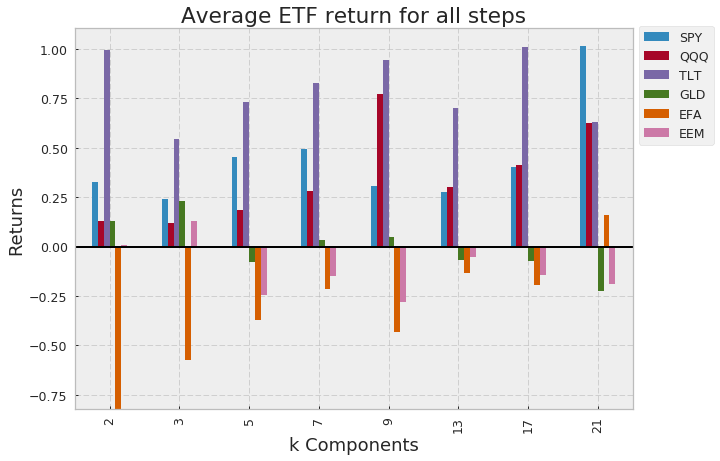

In [118]:
plot_all_bar_agg_by_steps(agg_dfs)

SPY    0.438749
QQQ    0.352509
TLT    0.795962
GLD   -0.000197
EFA   -0.322259
EEM   -0.115484
dtype: float64

mean: 19.15466%


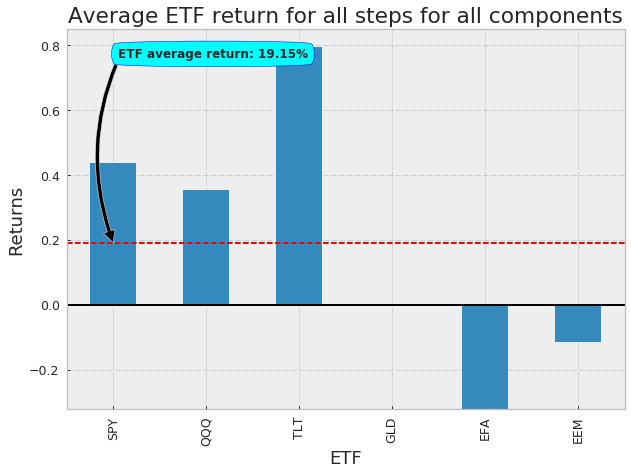

In [119]:
p(agg_dfs.mean())
p()
p(f'mean: {agg_dfs.mean().mean():3.5%}', )
plot_bar_agg_by_steps(agg_dfs)

In [115]:
def plot_bar_agg_by_ks(agg_dfs):
    plt.style.use('bmh')
    fig, ax = plt.subplots(figsize=(10,7))
    ax.axhline(y=0, color='k')
    agg_dfs.mean(axis=1).plot(kind='bar', ax=ax)
    ETF_avg = agg_dfs.mean(axis=1).mean()
    ax.axhline(y=ETF_avg, color='red', ls='--')
    # annotate the avg
    lo, hi = ax.get_ylim()
    bbox_props = dict(boxstyle="round4, pad=0.6", fc="cyan", ec="b", lw=.5)
    ax.annotate(f'ETF average return: {ETF_avg:3.2%}', 
                fontsize=12, fontweight='demi',
                xy=(0, ETF_avg), 
                xycoords='data', 
                xytext=(0.05, (hi-lo)*0.65), 
                #textcoords = 'offset points',
                arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0.2"),
                bbox=bbox_props)
    plt.title(f'Average ETF return for all steps by components (k)')
    ax.set_ylabel('Returns')
    ax.set_xlabel('k Components')
    #ax.legend(loc = "center left", bbox_to_anchor = (1, 0.85), numpoints = 1)  
    #file_str = DIR + f'agg_result_eval/Agg-all-return-by-steps.png'
    #fig.savefig(file_str, dpi=300, bbox_inches="tight")
    #plt.close(fig)
    return   

2     0.127127
3     0.114997
5     0.112650
7     0.212276
9     0.225467
13    0.169749
17    0.234671
21    0.335436
dtype: float64

mean: 19.15466%


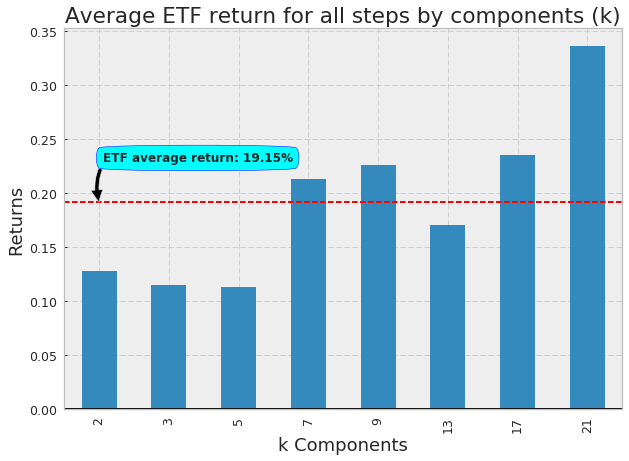

In [116]:
# average return for all steps by k
#agg_dfs.mean(axis=1).plot(kind='bar')
p(agg_dfs.mean(1))
p()
p(f'mean: {agg_dfs.mean(1).mean():3.5%}', )
plot_bar_agg_by_ks(agg_dfs)

In [ ]:
# evaluate aggretgate strat (etf return) by step

In [ ]:
        nRight = df.query('in_rng==1').shape[0]
        accuracy = nRight / df.shape[0]

In [ ]:
# collect and aggregate accuracy numbers

# get prediction df


In [68]:
mpl.font_manager._rebuild()

set([f.name for f in mpl.font_manager.fontManager.ttflist])

{'Abyssinica SIL',
 'Accanthis ADF Std',
 'Accanthis ADF Std No2',
 'Accanthis ADF Std No3',
 'Amiri',
 'Amiri Quran',
 'Anonymous',
 'Anonymous Pro',
 'Antic Slab',
 'Asana Math',
 'Bitstream Vera Sans',
 'Bitstream Vera Sans Mono',
 'Bree Serif',
 'Cabin',
 'Caladea',
 'CamingoCode',
 'Cantarell',
 'Carlito',
 'Comfortaa',
 'Convergence',
 'DejaVu Sans',
 'DejaVu Sans Display',
 'DejaVu Sans Mono',
 'DejaVu Serif',
 'DejaVu Serif Display',
 'EB Garamond',
 'EB Garamond Initials',
 'EB Garamond Initials Fill1',
 'EB Garamond Initials Fill2',
 'Fira Mono',
 'FontAwesome',
 'FreeMono',
 'FreeSans',
 'FreeSerif',
 'GFS Artemisia',
 'GFS Baskerville',
 'GFS BodoniClassic',
 'GFS Complutum',
 'GFS Didot',
 'GFS Didot Classic',
 'GFS Gazis',
 'GFS Neohellenic',
 'GFS Olga',
 'GFS Porson',
 'GFS Solomos',
 'GFS Theokritos',
 'Garuda',
 'Gentium',
 'Gentium Basic',
 'Gentium Book Basic',
 'Gentium Plus',
 'GentiumAlt',
 'Gillius ADF',
 'Gillius ADF Cd',
 'Gillius ADF No2',
 'Gillius ADF No2 C

In [122]:
# adk is list of tuples 
#   with tuple = (k, sym, return-series)
#   this output is for step=3
agg_dfs_k_f = pkl_loc + 'aggs_dfs_' + f_suffix
with open(agg_dfs_k_f, 'rb') as f:
    adk = pickle.load(f)

ks = np.unique([x[0] for x in adk])
ks    

array([ 2,  3,  5,  7,  9, 13, 17, 21])

In [120]:
# agg returns into df

def concat_by_k(list_tups, k):
    list_dfs = []
    for elm in list_tups:
        if elm[0] == k:
            tmp_ser = elm[-1]
            tmp_ser.name = elm[1]
            tmp_df = tmp_ser.to_frame()
            list_dfs.append(tmp_df)    
    concat_df = pd.concat(list_dfs)
    return concat_df

def plot_bar(concat_df, k):
    plt.style.use('bmh') 
    fig, ax = plt.subplots(figsize=(10,7))
    ax.axhline(y=0, color='k')
    concat_df.mean().sort_values().plot(kind='bar', ax=ax)
    ETF_avg = concat_df.mean().mean()
    ax.axhline(y=ETF_avg, color='red', ls='--')
    # annotate the avg
    lo, hi = ax.get_ylim()
    bbox_props = dict(boxstyle="round4, pad=0.6", fc="cyan", ec="b", lw=.5)
    ax.annotate(f'ETF average return: {ETF_avg:3.2%}', 
                fontsize=12, fontweight='demi',
                xy=(0, ETF_avg), 
                xycoords='data', 
                xytext=(-.05, (hi-lo)/5 ), 
                #textcoords = 'offset points',
                arrowprops=dict(facecolor='black', connectionstyle="arc3,rad=0.2"),
                bbox=bbox_props               )
    plt.suptitle(f'ETF Mean Return\nk = {k}')
    ax.set_ylabel('Returns')
    ax.set_xlabel('ETF')    
    return

#df1 = concat_by_k(adk, 3)
#plot_bar(df1, 3)

CPU times: user 744 ms, sys: 4 ms, total: 748 ms
Wall time: 748 ms


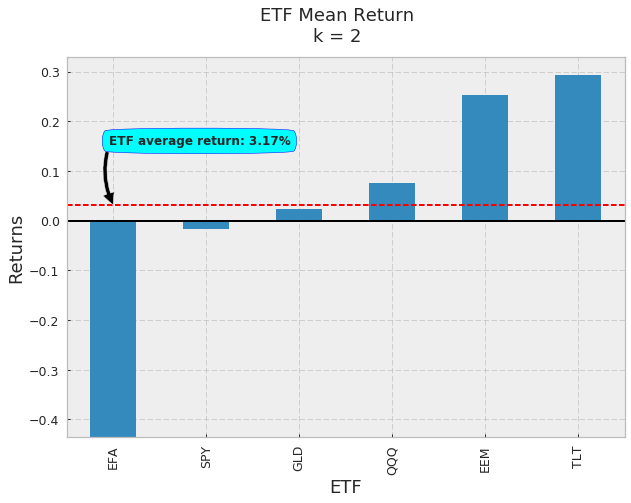

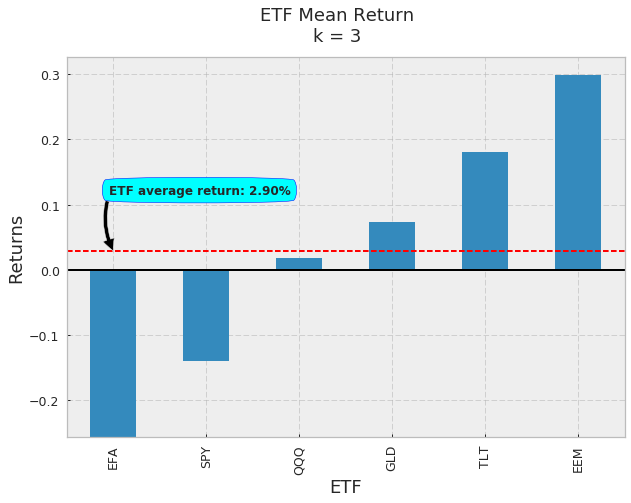

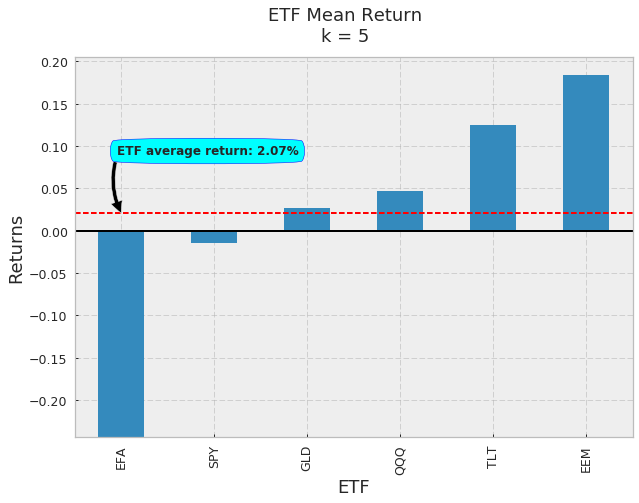

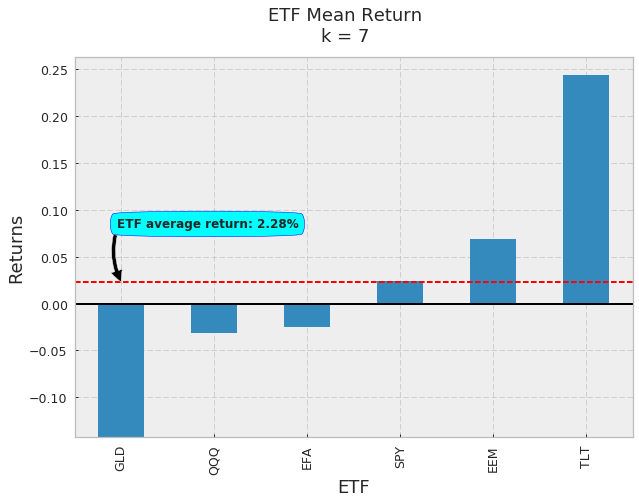

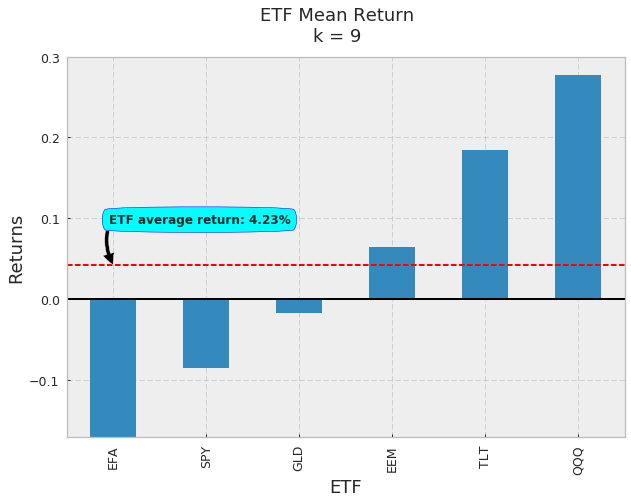

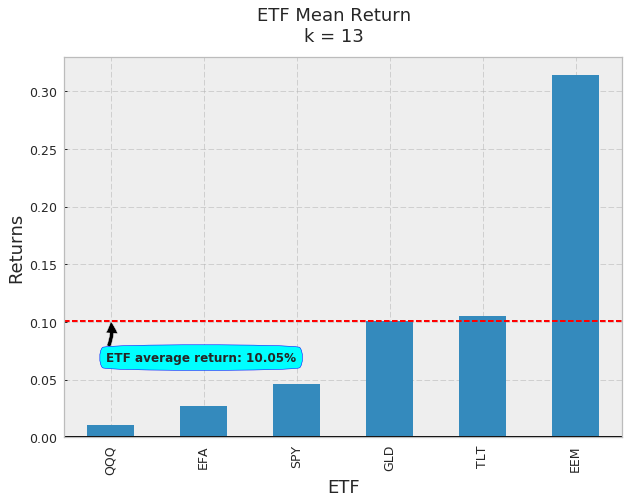

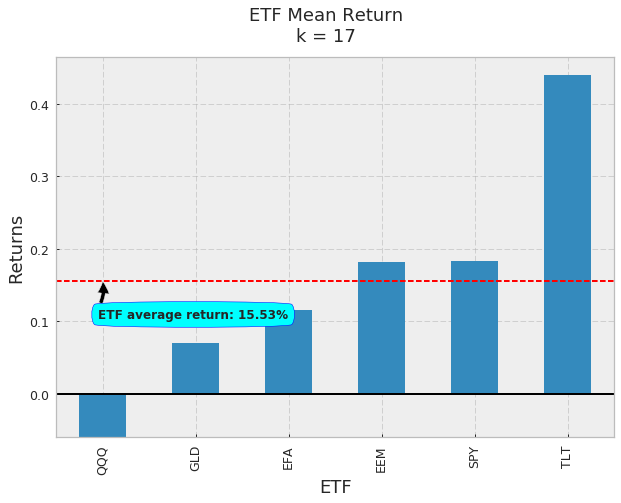

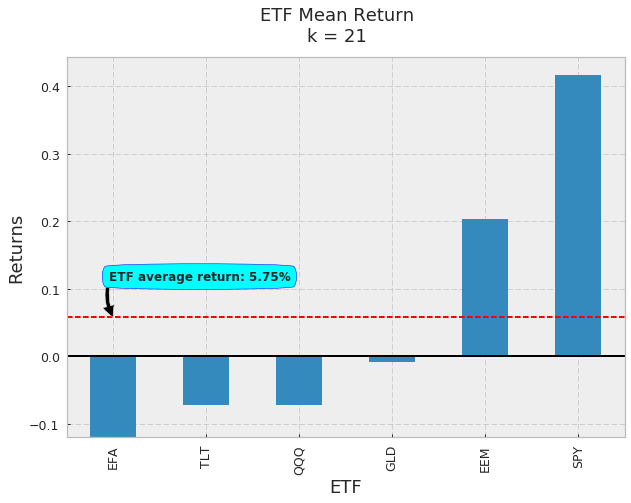

In [123]:
%%time
#plt.style.use('bmh')  
# these are by individual steps
# for example this is likely output with steps = 3
etf_avg_ret = {}
for k in ks: 
    tmp_df = concat_by_k(adk, k)
    etf_avg_ret[k] = tmp_df.mean().mean()    
    plot_bar(tmp_df, k)

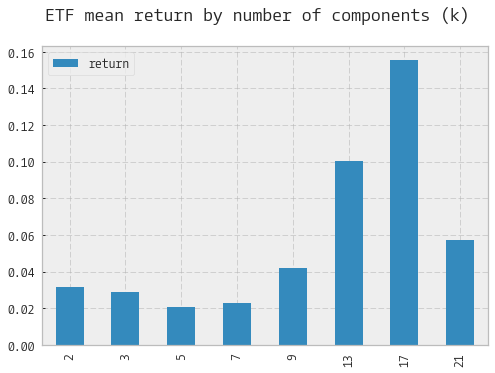

In [140]:
ret_by_k = (pd.DataFrame.from_dict(etf_avg_ret, orient='index')).rename(columns={0:'return'})
ret_by_k.plot(kind='bar')
plt.suptitle('ETF mean return by number of components (k)')

In [124]:
adk

[(2, 'SPY', Dates
  2008-01-04    0.000000
  2008-01-07   -0.000850
  2008-01-08   -0.017130
  2008-01-09   -0.006674
  2008-01-15   -0.006674
  2008-01-16   -0.015324
  2008-01-17   -0.041582
  2008-01-18   -0.051903
  2008-01-17   -0.051903
  2008-01-18   -0.062223
  2008-01-22   -0.072422
  2008-01-23   -0.048685
  2008-02-05   -0.048685
  2008-02-06   -0.056770
  2008-02-07   -0.050177
  2008-02-08   -0.056619
  2008-02-29   -0.056619
  2008-03-03   -0.059014
  2008-03-04   -0.062841
  2008-03-05   -0.056545
  2008-03-06   -0.056545
  2008-03-07   -0.066899
  2008-03-10   -0.080170
  2008-03-11   -0.044863
  2008-03-19   -0.044863
  2008-03-20   -0.026509
  2008-03-25   -0.025545
  2008-03-26   -0.037856
  2008-03-28   -0.037856
  2008-03-31   -0.034364
                  ...   
  2016-02-09    0.146310
  2016-02-10    0.145447
  2016-02-08    0.145447
  2016-02-09    0.145501
  2016-02-10    0.144637
  2016-02-11    0.131544
  2016-02-11    0.131544
  2016-02-12    0.151951
  2016-

In [125]:
def plot_lines(list_tups, k):
    fig, ax = plt.subplots(figsize=(10,7))
    ax.axhline(y=0, color='k')
    for elm in list_tups:
        if elm[0] == k:
            tmp_ser = elm[-1]
            ax.plot(tmp_ser.index, tmp_ser.values, label=elm[1])
            ax.set_xlim(tmp_ser.index[0])
            ax.legend(loc='upper left', fancybox=True, shadow=True, 
                      bbox_to_anchor = (1, 0.85)) 
            # fontsize=11, frameon=True).get_frame().set_edgecolor('blue')
            plt.suptitle(f'Strategy Cumulative Returns\nk = {k}')   
    return

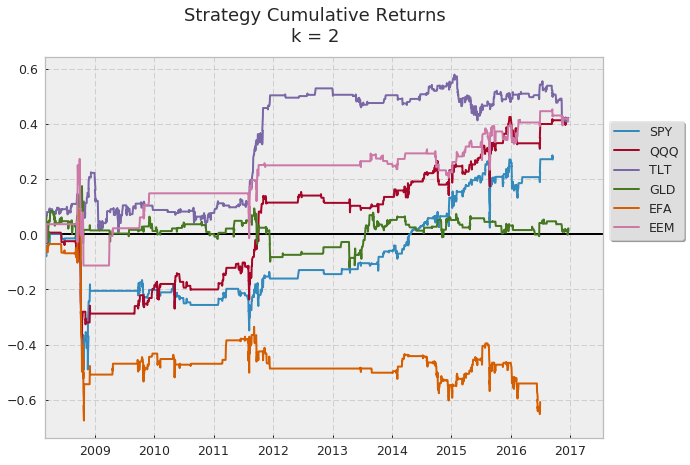

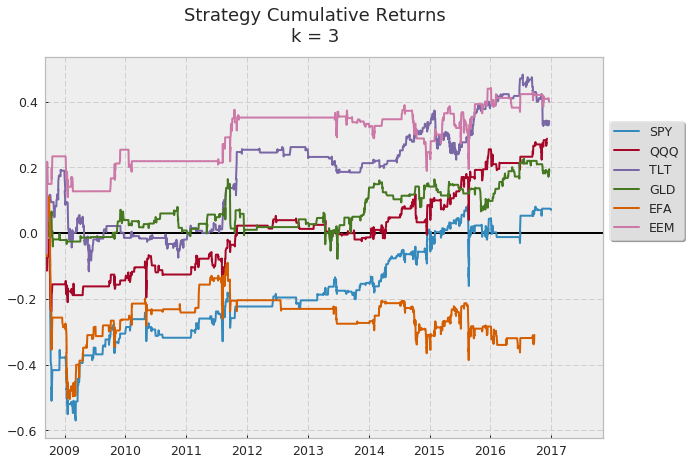

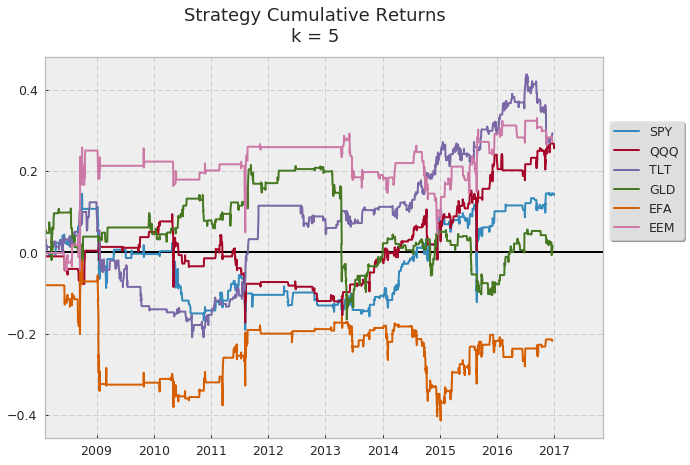

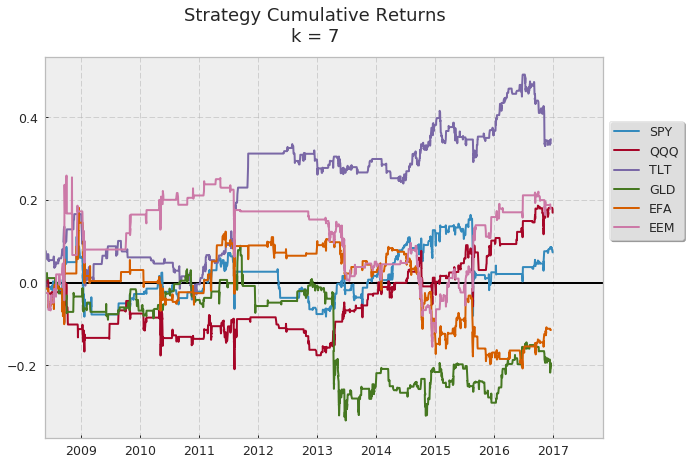

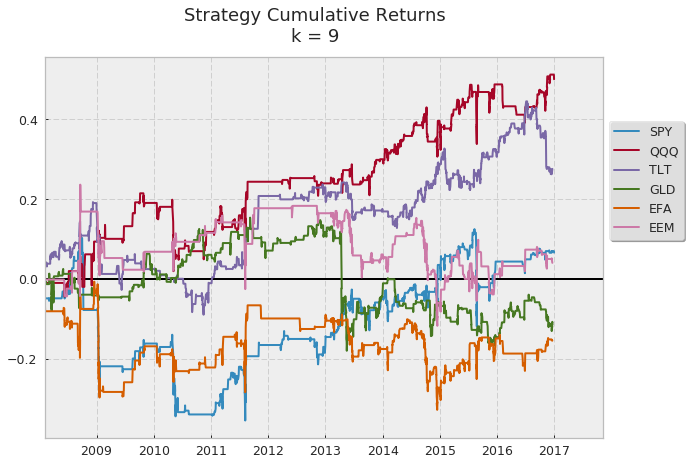

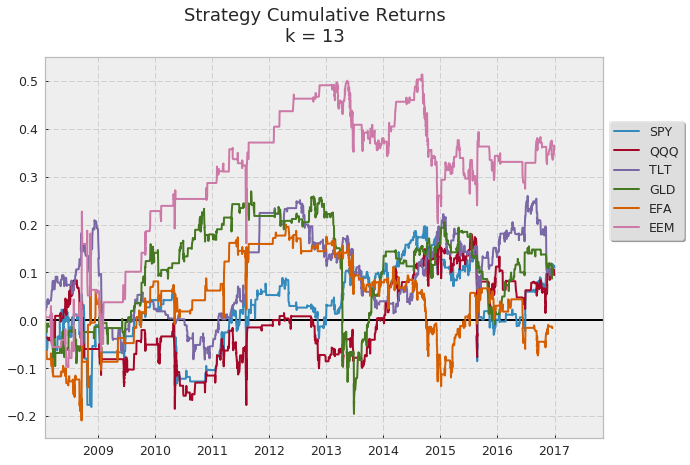

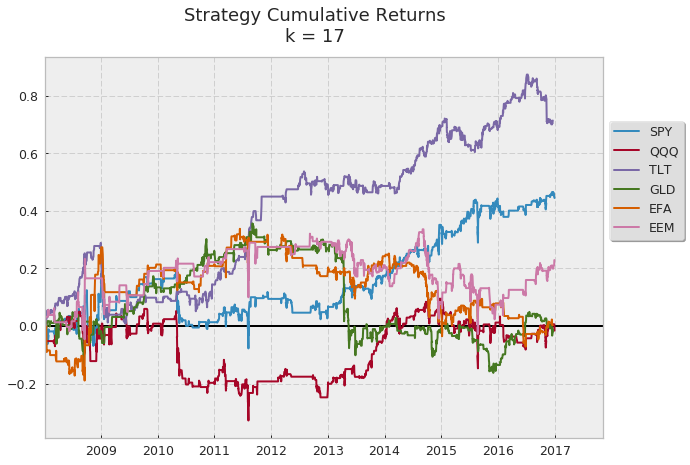

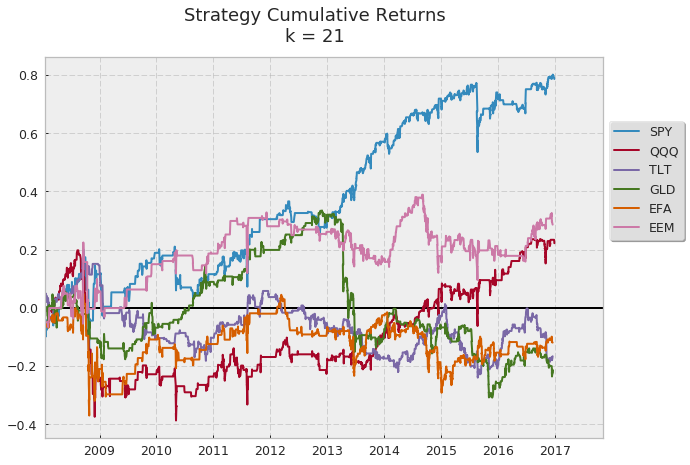

In [126]:
for k in ks: plot_lines(adk, k)

In [ ]:
#